# CCPIV and By Hand *Chandra* Spectral Profiles
G. Tremblay made the CCCPIV profiles for Osase using the *Chandra Cluster Cosmology Project IV* codes from Tremblay & Vikhlinin (in prep). We use these for large scale spectrla analysis (e.g. M_500, R_500)


 Osase simply did it the old fashioned way for the spectral analysis in the central 200 arcseconds

In [50]:
import os
import numpy as np

from astropy.io import ascii
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import astropy.constants as const
from astropy.table import QTable

import matplotlib.pyplot as plt

import pandas as pd
import glob
from types import SimpleNamespace
import scipy

In [2]:
#About A2597
name = 'Abell 2597'
rah, decd = '23h25m19.7s', '-12d07m27s'
coord = SkyCoord(rah, decd, frame='icrs')
ra = coord.ra.degree
dec = coord.dec.degree
radius = Angle(20, u.arcsec)

z = 0.0821 # best redshift for A2597
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)

angular_diameter_distance = cosmo.angular_diameter_distance(z=z) # in Mpc
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.0821, we have 1.5458 kpc / arcsec


#### Directory structure

In [14]:
print('These are the data products GT created for CCPIV and OMO created by hand: ')
profiles_dir = 'spectral_profiles/'
os.listdir(profiles_dir)

These are the data products GT created for CCPIV and OMO created by hand: 


['tprof.dat',
 'tot.fit.2',
 'byhand_020125_fine_lss_annuli_abundance.npy',
 'masses.par',
 'accept_main_table.txt',
 'tprof.par']

#### Parse  Profiles and Tables

In [47]:
#functions

def parse_accept_table(accept_table_file):
    """ read ACCEPT Table and asssign units"""

    # Read in the raw (unitless) accept table as an astropy table
    accept_table_raw = ascii.read(accept_table_file)

    # assign units to each column
    Name = accept_table_raw['Name']
    Rin = accept_table_raw['Rin'] * u.Mpc
    Rout = accept_table_raw['Rout'] * u.Mpc
    nelec = accept_table_raw['nelec'] * u.cm**(-3)
    neerr = accept_table_raw['neerr'] * u.cm**(-3)
    Kitpl = accept_table_raw['Kitpl'] * u.keV * u.cm**2
    Kflat = accept_table_raw['Kflat'] * u.keV * u.cm**2
    Kerr = accept_table_raw['Kerr'] * u.keV * u.cm**2
    Pitpl = accept_table_raw['Pitpl'] * u.dyne * u.cm**(-2)
    Perr = accept_table_raw['Perr'] * u.dyne * u.cm**(-2)
    Mgrav = accept_table_raw['Mgrav'] * u.M_sun
    Merr = accept_table_raw['Merr'] * u.M_sun
    Tx = accept_table_raw['Tx'] * u.keV
    Txerr = accept_table_raw['Txerr'] * u.keV
    Lambda = accept_table_raw['Lambda'] * u.erg * u.cm**3 / u.s
    tcool52 = accept_table_raw['tcool5/2'] * u.Gyr
    tcool52err = accept_table_raw['t52err'] * u.Gyr
    tcool32 = accept_table_raw['tcool3/2'] * u.Gyr
    tcool32err = accept_table_raw['t32err'] * u.Gyr

    names = ('Name', 'Rin', 'Rout', 'nelec', 'neerr', 'Kitpl',
             'Kflat', 'Kerr', 'Pitpl', 'Perr', 'Mgrav', 'Merr',
             'Tx', 'Txerr', 'Lambda', 'tcool52', 't52err',
             'tcool32', 't32err'
             )

    # Create the new table as a QTable with units 
    main_accept_table = QTable(
        [Name, Rin, Rout, nelec, neerr, Kitpl,
         Kflat, Kerr, Pitpl, Perr, Mgrav, Merr,
         Tx, Txerr, Lambda, tcool52, tcool52err,
         tcool32, tcool32err], names=names
    )

    return main_accept_table

def parse_sbprof_parfile(tot_fit_file, line_start=88, line_end=100):
    '''read tot.fit.2 file and populate a dictionary of the relevant fit parameters. 
    The first 87 lines or so are the actual ne*np profiles. 
    Need to check that 93:105 is consistent across all tot.fit.2 files for full CCCPIV 
    implementation'''
    
    with open(tot_fit_file) as r:
        # I *think* [93:105] is consistent across all tot.fit.2 files
        lines = r.read().splitlines()[line_start:line_end]

        sbprof_par_dict = {}
        
        for line in lines:

            # These splits have a ton of whitespace so this is easier way to do it
            pair= [x.strip() for x in line.split('//')[0].split(' = ')]
            #float_value = float(''.join(filter(str.isdigit, pair[1])))
            
            sbprof_par_dict[pair[0]] =float(pair[1]) #float_value

    return sbprof_par_dict


def parse_mass_parfile(mass_parfile):

    mass_par_dict = {}

    with open(mass_parfile) as r:
        lines = r.read().splitlines()

    for line in lines:
        pair = line.split(' = ')
        mass_par_dict[pair[0]] = float(pair[1])

    return mass_par_dict

def parse_tprof_parfile(tprof_parfile):
    
    '''read tprof.par from CCCPIV and parse it'''
    
    tprof_par_dict = {}
    
    with open(tprof_parfile) as f:
        lines = f.read().splitlines() 
    
    for line in lines:
        pair = line.split(' = ')
        
        if pair == ['fit_T_acool=no']:
            continue
        
        tprof_par_dict[pair[0]] = float(pair[1])
    
    return tprof_par_dict

def M_r(T, rho_g, r):
    """ 
    Vikhlinin (2006) eqn 7
    """
    dln_rho_g = np.diff(np.log(rho_g)) / np.diff(np.log(r)) 

    dln_T = np.diff(np.log(T)) / np.diff(np.log(r))

    return -3.68e13 * T[:-1] * r[:-1] * (dln_rho_g + dln_T) 

def vikhlinin_temperature_fit(tprof_pars: dict, radius_array=None):

    ''' This is the famous Vikhlinin et al. (2006) analytic multi-component temperature profile fit to a sample of galaxy clusters. 
    It takes into acccount things like cool cores, etc. 
    
    '''
    
    # We need this dictionary's key/value pairs to become variables we can use directly (otherwise we need to query the dictionary every time, which is too much text). 
    
    n = SimpleNamespace(**tprof_pars) # converting a dictionary into namespace 
    
    ''''''
    if radius_array is None:
        #tfit_radius = [float(pow(10.0,(i-1)*3.6/999.0)) for i in list(range(1,1000))]
        tfit_radius = np.arange(0,5000,1)
    elif radius_array is not None:
        tfit_radius = radius_array

    a = tfit_radius / n.T_rt
    tmain = pow(a,-n.T_a)/pow((1+pow(a,n.T_b)),(n.T_c/n.T_b))

    b = pow(tfit_radius/n.T_rcool,n.T_acool)
    tcool = (b+n.T_tmin)/(b+1)
    tfit_t = n.T0*tcool*tmain

    return np.array(tfit_radius),np.array(tfit_t)


In [10]:
main_accept_table = parse_accept_table(profiles_dir+ 'accept_main_table.txt')
grouped_accept_table = main_accept_table.group_by('Name')
mass_results = parse_mass_parfile(profiles_dir + 'masses.par')

sbprof_par_dict = parse_sbprof_parfile(profiles_dir + 'tot.fit.2')
tprof_par_dict = parse_tprof_parfile(profiles_dir + 'tprof.par')

tprof_datfile_names = ['Bin', 'T(keV)', 'Terr-', 'Terr+', 'Terr-90percent', 
                       'Terr+90percent', 'Abundance (solar)', 'Abundance_err (solar)', 
                       'nH (1e20 cgs)', 'nH_err (1e20 cgs)', 'T syserr bkg', 
                       'T syserr foregrd', 'G9']

#table of best-fit parameters from CCCPIV. Parse it into a dictionary. 
tprof = ascii.read(profiles_dir+'tprof.dat', names=tprof_datfile_names)


In [11]:
print("alpha: {}".format(sbprof_par_dict['alpha']))

alpha: 2.4083


In [13]:
#print(mass_results)
print(f"M500: {mass_results['M500_Y']:.2e} $\pm$ {mass_results['eM500_Y']:.2e}")
print(f"R500: {mass_results['R500_Y']:.2f} $\pm$ {mass_results['eR500_Y']:.2f}")


m500 = mass_results['M500_Y'] * u.solMass
r500 = mass_results['R500_Y'] * u.kpc

M500: 2.28e+14 $\pm$ 1.80e+12
R500: 904.80 $\pm$ 2.40


The spectral profiles from which the following is calaulcated is shown here 

<img src="final_cccp4_profiles/temperature_profile_regions.png" alt="regions" width="600"/>


#### Plot by hand profiles

In [16]:
profiles_path = glob.glob(profiles_dir + '*020125*.npy')[0]

#### Surface Brightness Profile

In [17]:
obsids = [ # '922', # 922 is in FAINT mode and has a terrible flare, let's just ditch it
          '6934', # 56.0 ksec, Clarke ACIS-S3 VFAINT
          '7329', # 60.11 ksec, Clarke ACIS-S3 VFAINT
          '19596', # 69.39 ksec, Tremblay ACIS S3 VFAINT
          '19597', # 44.52
          '19598', # 14.34
          '20626', # 24.73
          '20627', # 20.85
          '20628', # 10.92
          '20629', # 56.36
          '20805', # 53.4
          '20806', # 37.62
          '20811', # 79.85
          '20817'] # 62.29

In [20]:

# c2e means "counts to emission measure" - yes, this is bad ambiguous naming and I don't recommend it. 

sb_prof_dir = profiles_dir
sb_profile_names = ['RIN', 'ROUT', 'IGNORE1', 'IGNORE2', 'SUR_BRI', 'SUR_BRI_ERR']
c2e_names = ['RIN', 'ROUT', 'R_KPC', 'C2EMM', 'GOV5', 'GOV6', 'GOV7', 'GOV8', 'GOV9', 'GOV10', 'GOV11']

bi_obsids = []
fi_obsids = []
counts2emm_bi_obsids = []
counts2emm_fi_obsids = []

for ido, obsid in enumerate(obsids):
    sb_profile_bi = ascii.read(sb_prof_dir + 'prof.700-2000.' + obsid + '_bi.flat', names=sb_profile_names)
    sb_profile_fi = ascii.read(sb_prof_dir + 'prof.700-2000.' + obsid + '_fi.flat', names=sb_profile_names)
    counts2emm_sb_profile_bi = ascii.read(sb_prof_dir + 'prof.700-2000.' + obsid + '_bi.flat.spec', names=c2e_names)
    counts2emm_sb_profile_fi = ascii.read(sb_prof_dir + 'prof.700-2000.' + obsid + '_fi.flat.spec', names=c2e_names)

    bi_obsids.append(sb_profile_bi)
    fi_obsids.append(sb_profile_fi)
    counts2emm_bi_obsids.append(counts2emm_sb_profile_bi)
    counts2emm_fi_obsids.append(counts2emm_sb_profile_fi)


# including the front-illuminated chips, which are WAY outside of the cluster and basically all background

# profiles = [sb_profile_17218_bi, sb_profile_17218_fi, sb_profile_18689_bi, sb_profile_18689_fi]
# c2etables = [counts2emm_sb_profile_17218_bi, counts2emm_sb_profile_17218_fi, counts2emm_sb_profile_18689_bi, counts2emm_sb_profile_18689_fi]

# BI chips only (i.e. the nominal aimpoint )
profiles = bi_obsids #[sb_profile_17218_bi, sb_profile_18689_bi]
c2etables = counts2emm_bi_obsids# [counts2emm_sb_profile_17218_bi, counts2emm_sb_profile_18689_bi]


sb_profile_fit_names = ['R', # radius in kpc, r=(r1+r2)/2 where r1 and r2 are the inner and outer radii of the annulus
                        'FIT', # Emission measure,  E=\int ne np dl, in units of cgs per kpc^2 (sorry :). E.g., you need to divide these numbers by 9.52141e+42 (i.e. kpc^2 in cm) to get to the cgs units. C.f. CCCP2 fig5.
                        'ne_np', # np * ne at radius r (cgs)
                        'sqrt(ne_np)', # sqrt(ne*np) at radius r (cgs units)
                        'outer_annulus_r', #r2 (outer annulus radius) in kpc, cf col 1
                        'gas_mass', # gas mass within r < r2, Msolar
                        'spherical_overdensity'] # Spherical overdensity of the gas mass with respect to the mean cosmic density of baryons.

sb_profile_fit = ascii.read (profiles_dir + 'tot.fit.2',
                           names = sb_profile_fit_names,
                           data_end=85)



Text(0.5, 1.0, 'Cluster X-ray Surface Brightness Profile')

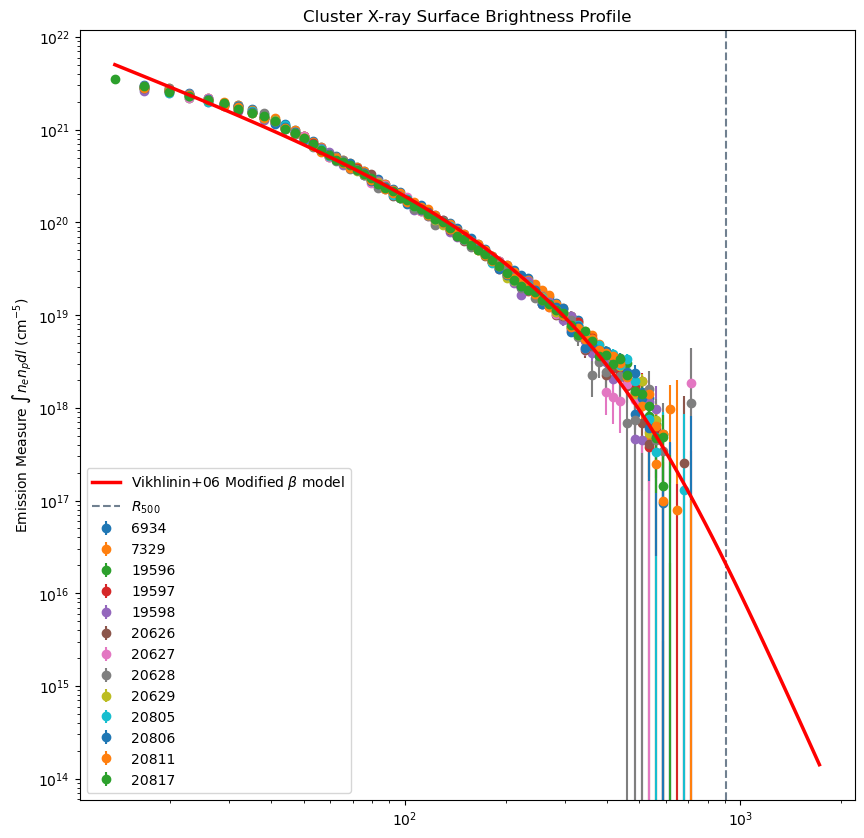

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

sb_df = pd.DataFrame()

for i, profile in enumerate(profiles):

    x = c2etables[i]['R_KPC']
    y = (profile['SUR_BRI']  * c2etables[i]['C2EMM'] - sbprof_par_dict['bg']) / 9.52141e+42 # this factor is cm2 per kpc2
    err = (profile['SUR_BRI_ERR'] * c2etables[i]['C2EMM']) / 9.52141e+42

    ax.errorbar(x,y, yerr=err, ls='none', marker='o', label=obsids[i])

    obsid = obsids[i]
    sb_df[f'emission_measure_{obsid}'] = y[:64]
    sb_df[f'emission_measure_err_{obsid}'] = err[:64]

sb_df[f'r_kpc'] = x[:64]
sb_fit_df = pd.DataFrame()

sb_fit_x = sb_profile_fit['R'] 
sb_fit_y = sb_profile_fit['FIT']/ 9.52141e+42

sb_fit_df[f'emission_measure_fit'] = sb_fit_y
sb_fit_df[f'r_fit'] = sb_fit_x

ax.plot(sb_fit_x, sb_fit_y, zorder=3, label=r'Vikhlinin+06 Modified $\beta$ model', color='red', lw=2.5)


ax.set_ylabel(r'Emission Measure $\int n_e n_p dl$ (cm$^{-5}$)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5, label=r'$R_{500}$') # R_500 from the CCCPIV best fit.
ax.legend()
ax.set_title("Cluster X-ray Surface Brightness Profile")




### Mass Profile and Cooling Luminosity

Text(0.5, 0, 'Radius (kpc)')

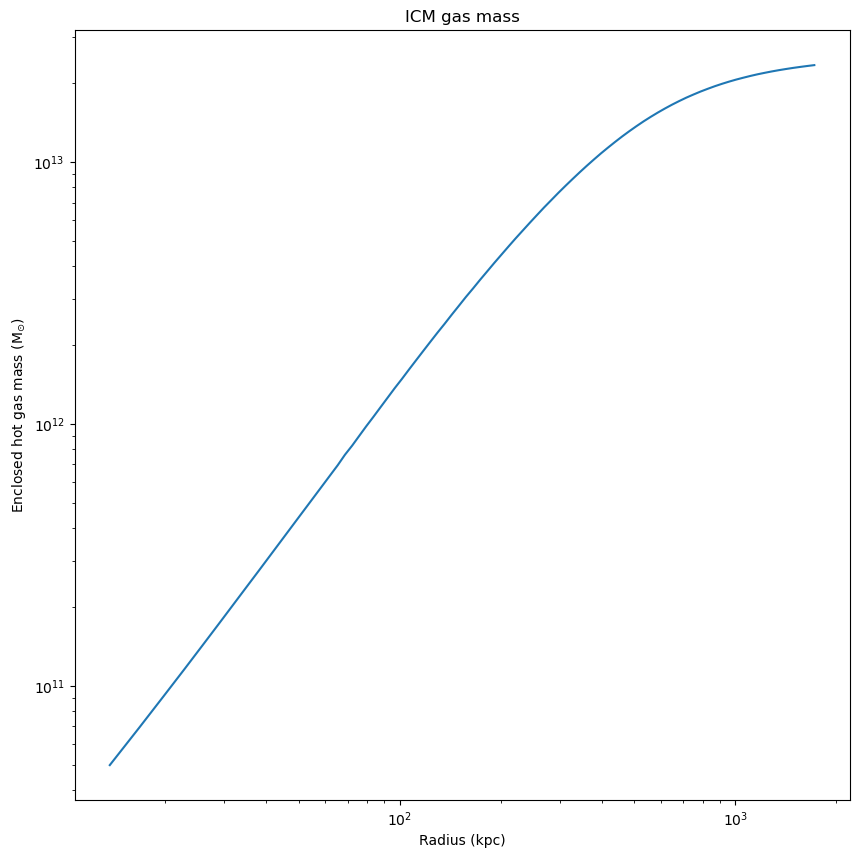

In [42]:
fig, ax = plt.subplots(figsize=(10,10))

x = sb_profile_fit['R']
y = sb_profile_fit['gas_mass']

ax.plot(x,y)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title('ICM gas mass')
ax.set_ylabel(r'Enclosed hot gas mass (M$_{\odot}$)')
ax.set_xlabel(r'Radius (kpc)')

In [51]:


radius = (sb_profile_fit['R'] * u.kpc).to(u.Mpc)
density = (sb_profile_fit['gas_mass'] * u.solMass/(4*np.pi * radius**3/3)).to(u.solMass/u.Mpc**3)
regrid_tfitx, regrid_tfity = vikhlinin_temperature_fit(tprof_par_dict, sb_profile_fit['R'])
t_kev = regrid_tfity * u.keV

total_mass_xray = M_r(t_kev.value, density.value, radius.value) * u.solMass
total_mass_xray = np.append(total_mass_xray, total_mass_xray[-1])

Text(0.5, 0, 'Radius (kpc)')

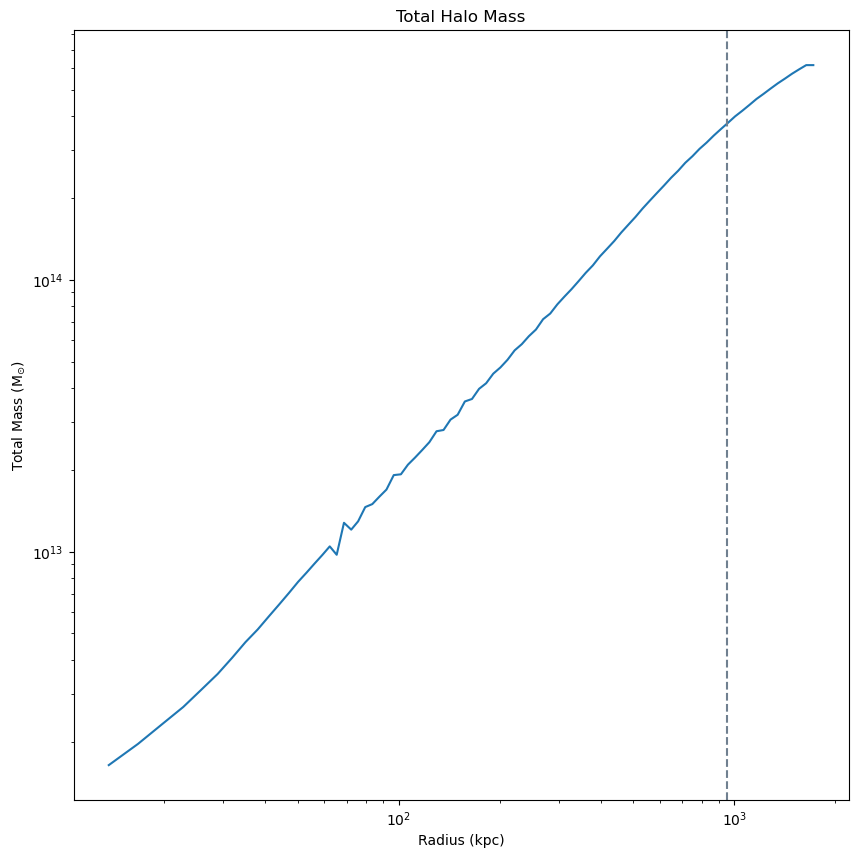

In [52]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(radius.to(u.kpc), total_mass_xray)

ax.set_yscale('log')
ax.set_xscale('log')

ax.axvline(950, color='slategray', ls='--', lw=1.5) 

ax.set_title('Total Halo Mass')
ax.set_ylabel(r'Total Mass (M$_{\odot}$)')
ax.set_xlabel(r'Radius (kpc)')

#### Cooling Rate

mgas/tcool

In [53]:
def coolingFunction(kT):
    r"""
    Implement the Tozzi & Norman (2001) cooling function.

    This is an analytic fit to Sutherland & Dopita (1993), shown
    in Equation 16 of Parrish, Quataert, & Sharma (2009),
    as well as Guo & Oh (2014).

    See here: arXiv:0706.1274. The equation is:

    $\Lambda(T) = [C_1 \left( \frac{k_B T}{\mathrm{keV}} \right)^{-1.7}
                  + C_2\left( \frac{k_B T}{\mathrm{keV}} \right)^{0.5}
                  + C_3] \times 10^{-22}$
    """
    # For a metallicity of Z = 0.3 Z_solar,
    C1 = 8.6e-3
    C2 = 5.8e-2
    C3 = 6.3e-2

    alpha = -1.7
    beta = 0.5

    # kT.value is supposed to be unitless,
    # the kT in the real equation is divided by keV. I'm not cheating!
    coolingFunction = (C1 * kT.value**alpha
                       + C2 * kT.value**beta
                       + C3
                       ) * 1.0e-22 * (u.erg * u.cm**3 / u.s)

    return coolingFunction

In [62]:
r = sb_fit_x
regrid_tfitx, regrid_tfity = vikhlinin_temperature_fit(tprof_par_dict, r)
t_kev = regrid_tfity * u.keV

# use McDonald +19 Z/3 metallicity values, i.e
# . 
ne_np = sb_profile_fit['ne_np']
n_e = np.sqrt(1.199 * ne_np) * u.cm**-3
n_p = (1/1.199) * n_e 
n_h = 0.83 * n_e 

pressure_profile = (1.83 * n_e * t_kev).to(u.dyne/u.cm**2) # this gives pressure profile that is too high at lower r! 
# epressure_up 
entropy_profile = t_kev * n_e**(-2/3)

cooling_time = (3/2) * (((n_e + n_p) * t_kev) / (n_e * n_h * coolingFunction((t_kev))))
cooling_time = cooling_time.to(u.Gyr)

Within cooling radius of 31.94 kpc, the cooling rate is 173.21522598815443 solMass / yr
Within cooling radius of 62.36 kpc, the cooling rate is 211.91184191220444 solMass / yr


Text(0.5, 0, 'Radius (kpc)')

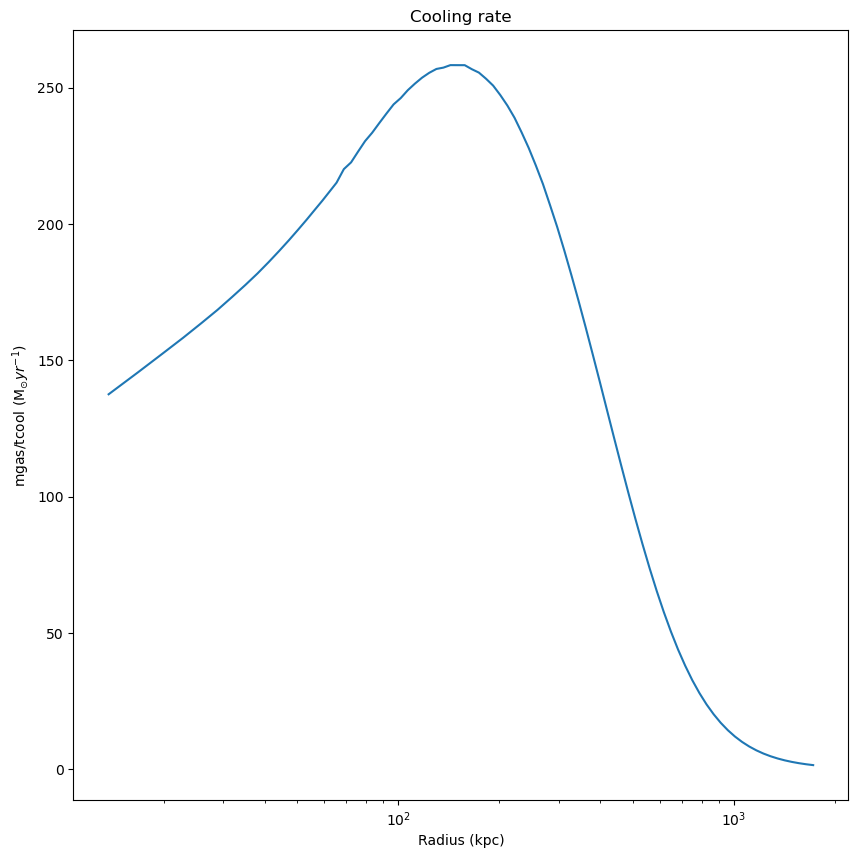

In [64]:
fig, ax = plt.subplots(figsize=(10,10))

x = sb_profile_fit['R']
y = sb_profile_fit['gas_mass'] * u.solMass

ax.plot(x,(y/cooling_time).to(u.solMass/u.yr))
cooling_rate = (y / cooling_time).to(u.solMass/u.yr)

id_rcool = 6
cooling_radius = x[id_rcool]
cooling_rate_radius = (y[id_rcool] / cooling_time[id_rcool]).to(u.solMass/u.yr)
print(f"Within cooling radius of {cooling_radius} kpc, the cooling rate is {cooling_rate_radius}")

id_tcool = 16
cooling_radius = r[id_tcool]
cooling_rate_radius = (y[id_tcool] / cooling_time[id_tcool]).to(u.solMass/u.yr)
print(f"Within cooling radius of {cooling_radius} kpc, the cooling rate is {cooling_rate_radius}")

# ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title('Cooling rate')
ax.set_ylabel(r'mgas/tcool (M$_{\odot} yr^{-1}$)')
ax.set_xlabel(r'Radius (kpc)')

In [71]:
r[16]

62.36

In [72]:
#cooling rate at shock fronts

edge_radii = [49, 62, 99, 156]

edge_ids = [12, 16, 26, 35]

for i, edge_id in enumerate(edge_ids):
    cooling_radius = r[edge_id]
    cooling_rate_radius = (y[edge_id] / cooling_time[edge_id]).to(u.solMass/u.yr)

    print(f"Within cooling radius of {cooling_radius} kpc, the cooling rate is {cooling_rate_radius}")

Within cooling radius of 50.19 kpc, the cooling rate is 197.84293081272602 solMass / yr
Within cooling radius of 62.36 kpc, the cooling rate is 211.91184191220444 solMass / yr
Within cooling radius of 101.61 kpc, the cooling rate is 246.19333303316313 solMass / yr
Within cooling radius of 157.58 kpc, the cooling rate is 258.2436774561393 solMass / yr


### Cooling Luminosity

In [73]:
def l_cool(mdot_cool, kT, mu=0.62):
    m_p = const.m_p
    return ((5./2.) * (mdot_cool/(mu * m_p)) * kT).to(u.erg/u.s)

tcool_kev = 3.5 * u.keV
cooling_luminosity = l_cool(cooling_rate, tcool_kev)

print("At the cooling radius of 60 kpc, the cooling luminosity is: ", cooling_luminosity[id_tcool])


for i, edge_id in enumerate(edge_ids):
    lcool_radius = l_cool(cooling_rate[edge_id], tcool_kev)
    print(f"Within cooling radius of {r[edge_id]} kpc, the cooling luminosity is: ", lcool_radius)


At the cooling radius of 60 kpc, the cooling luminosity is:  1.805037138550234e+44 erg / s
Within cooling radius of 50.19 kpc, the cooling luminosity is:  1.6852000081455945e+44 erg / s
Within cooling radius of 62.36 kpc, the cooling luminosity is:  1.805037138550234e+44 erg / s
Within cooling radius of 101.61 kpc, the cooling luminosity is:  2.09704236147613e+44 erg / s
Within cooling radius of 157.58 kpc, the cooling luminosity is:  2.199685606985767e+44 erg / s


Text(0.5, 0, 'Radius (kpc)')

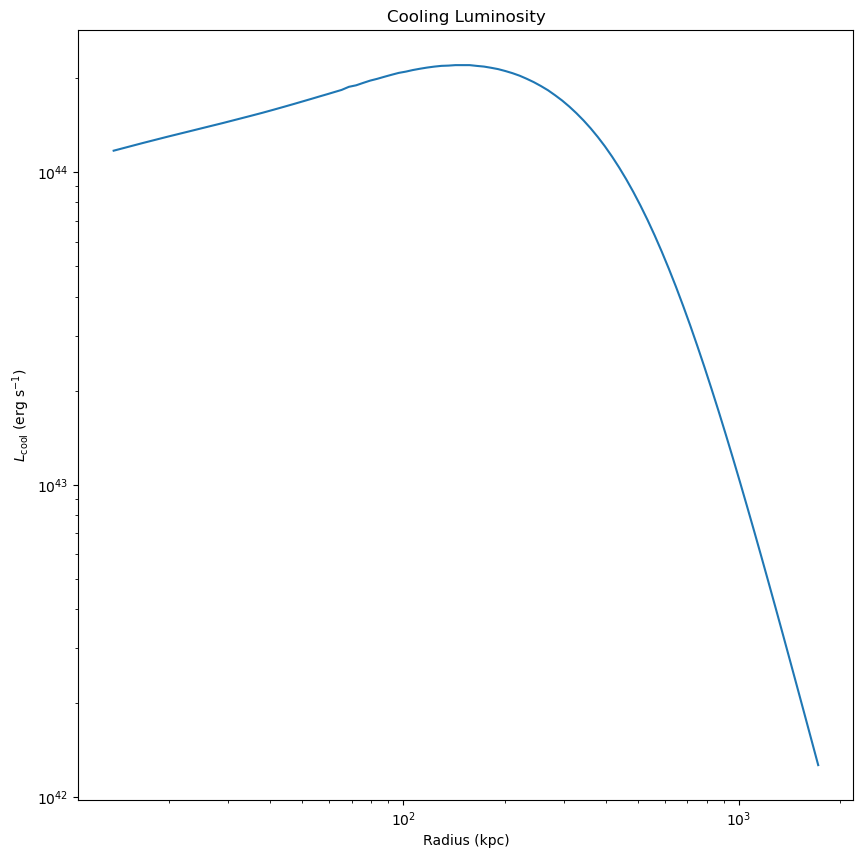

In [75]:
fig, ax = plt.subplots(figsize=(10,10))

x = sb_profile_fit['R']
y = sb_profile_fit['gas_mass'] * u.solMass

ax.plot(x,cooling_luminosity)
# cooling_rate = (y / cooling_time).to(u.solMass/u.yr)

# cooling_radius = r[14]
# cooling_rate_radius = (y[14] / cooling_time[14]).to(u.solMass/u.yr)
# print(f"Within cooling radius of {cooling_radius} kpc, the cooling rate is {cooling_rate_radius}")

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title('Cooling Luminosity')
ax.set_ylabel(r'$L_{\rm cool}$ (erg s$^{-1}$)')
ax.set_xlabel(r'Radius (kpc)')

## Core Spectral profiles

These were done by hand by OMO

In [23]:
profiles_path = glob.glob(profiles_dir + '*020125*.npy')[0]

def dm_error_prop(variables, variable_errs, function):
    """ error popagation for multiplication/division
        params:
            variables (list)
            variables_err (list)
            """

    error_list = []

    for idv, variable in enumerate(variables):
        variable_err = variable_errs[idv]
        error_list.append(np.power(variable_err/variable, 2))
    
    return function * np.sqrt(np.sum(np.array(error_list), axis=0))

def exp_error_prop(variable, variable_err, power):
    """ error propagation for exponent"""
    return np.power(variable, power) * (power) * (variable_err/variable)

def tcool(electron_density, tkev):
    #see mcdonald (2018) eqn 2
    proton_density = 0.92 * electron_density
    hydrogen_density = 0.83 * electron_density

    cooling_time = ((3/2) * ((electron_density + proton_density ) * tkev)
                    /(electron_density * hydrogen_density * coolingFunction(tkev))).cgs
                    
    return cooling_time

def coolingFunction(kT):
    r"""
    Implement the Tozzi & Norman (2001) cooling function.

    This is an analytic fit to Sutherland & Dopita (1993), shown
    in Equation 16 of Parrish, Quataert, & Sharma (2009),
    as well as Guo & Oh (2014).

    See here: arXiv:0706.1274. The equation is:

    $\Lambda(T) = [C_1 \left( \frac{k_B T}{\mathrm{keV}} \right)^{-1.7}
                  + C_2\left( \frac{k_B T}{\mathrm{keV}} \right)^{0.5}
                  + C_3] \times 10^{-22}$
    """
    # For a metallicity of Z = 0.3 Z_solar,
    C1 = 8.6e-3
    C2 = 5.8e-2
    C3 = 6.3e-2

    alpha = -1.7
    beta = 0.5

    # kT.value is supposed to be unitless,
    # the kT in the real equation is divided by keV. I'm not cheating!
    coolingFunction = (C1 * kT.value**alpha
                       + C2 * kT.value**beta
                       + C3
                       ) * 1.0e-22 * (u.erg * u.cm**3 / u.s)

    return coolingFunction

In [76]:
by_hand_profs = pd.DataFrame(np.load(profiles_path, allow_pickle=True))

flux = by_hand_profs['flux'].to_numpy() * u.erg / (u.cm**2 * u.s)
flux_upp_err = by_hand_profs['flux_up_err'].to_numpy() * u.erg / (u.cm**2 * u.s)
flux_low_err = by_hand_profs['flux_low_err'].to_numpy() * u.erg / (u.cm**2 * u.s)

#KT and norm
kTs = by_hand_profs['kT'].to_numpy() * u.keV
kT_upp_errs = by_hand_profs['kT_up_err'].to_numpy() * u.keV
kT_low_errs = by_hand_profs['kT_low_err'].to_numpy() * u.keV
#kT_errs = by_hand_profs['kT_err'].to_numpy() * u.keV

#abundance
abundances = by_hand_profs['abundance'].to_numpy()
abundance_upp_errs = by_hand_profs['abundance_up_err'].to_numpy()
abundance_low_errs = by_hand_profs['abundance_low_err'].to_numpy()

norms = by_hand_profs['norm'].to_numpy()
norm_upp_errs = by_hand_profs['norm_up_err'].to_numpy()
norm_low_errs = by_hand_profs['norm_low_err'].to_numpy()
#norm_errs = by_hand_profs['norm_err'].to_numpy()

radius_to_plot = by_hand_profs['radius'].to_numpy() * u.kpc
radius_err_to_plot = by_hand_profs['radius_err'].to_numpy() * u.kpc

r_inner_in_kpc = by_hand_profs['r_inner'].to_numpy() * u.kpc
r_outer_in_kpc = by_hand_profs['r_outer'].to_numpy() * u.kpc


volume = (4/3) * np.pi * (r_outer_in_kpc**3 - r_inner_in_kpc**3)

#electron density
electron_density = np.sqrt((norms * u.cm**-5 * 4 * np.pi * 
                            np.power(angular_diameter_distance.to(u.cm) * (1 + z), 2)) 
                            / (1.e-14 * 0.82 * volume.to(u.cm**3))) 
electron_density_upp_err = electron_density / (2*norms) * norm_upp_errs
electron_density_low_err = electron_density / (2*norms) * norm_low_errs

#pressure
pressure = (2 * electron_density * kTs).to(u.dyne/u.cm**2)
pressure_upp_err  = dm_error_prop([electron_density, kTs], [electron_density_upp_err, kT_upp_errs],
                                            pressure)
pressure_low_err  = dm_error_prop([electron_density, kTs], [electron_density_low_err, kT_low_errs],
                                            pressure)

#entropy
entropy  = kTs * np.power(electron_density, -2.0/3.0)
entropy_upp_err = dm_error_prop([kTs.value, np.power(electron_density, -2/3).value], 
                [kT_upp_errs.value, exp_error_prop(electron_density, electron_density_upp_err, -2/3) ],
                entropy)
entropy_low_err = dm_error_prop([kTs.value, np.power(electron_density, -2/3).value],
                [kT_low_errs.value, exp_error_prop(electron_density, electron_density_low_err, -2/3) ],
                entropy)

/var/folders/q9/nqsw_gnn1kq4pydg796lnc880000gn/T/ipykernel_85162/3803995102.py:64: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax4.set_ylim(0, 400)


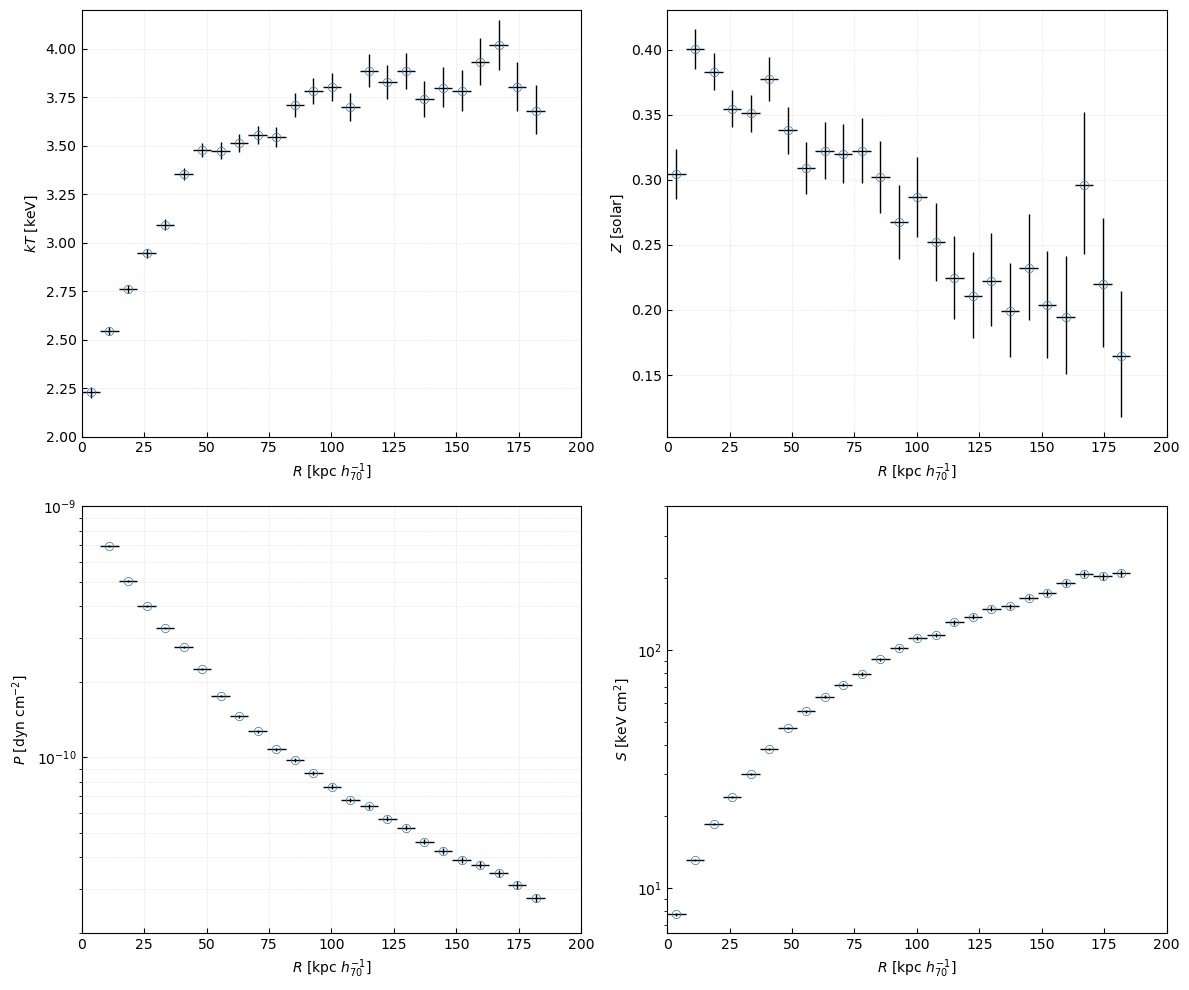

In [31]:
nr, nc = 2, 2
fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(6*nc, 5*nr))
gs1 = axes.ravel()

point_ms=6

#ax2

colors=['teal', 'k']
fill='full'
lw=0
ms=5
cp_alpha = 0.7#0.6
grid_alpha=0.3
cp_lw=2
lw_central=1
xlabel = r'$R$ [kpc $h_{70}^{-1}$]'

rmax = 200
mew=0.5

#-------------------------------------
# Pressure profile
#-------------------------------------
ax3 = fig.add_subplot(gs1[2]) 
ax3.errorbar(radius_to_plot, pressure, yerr=[pressure_low_err, pressure_upp_err], xerr=radius_err_to_plot,
             fmt='o',
             mfc = 'None',
            ecolor='k',
            mew=mew,
            ls='none',
            ms=point_ms,
            lw=1)

ax3.set_yscale('log')
ax3.set_ylim(10**(-10.7), 1e-9)
ax3.set_ylabel(r'$P$ [dyn cm$^{-2}$]')
ax3.set_xlim(0, rmax)

ax3.tick_params(axis="y",direction="in") #, pad=-22)
ax3.tick_params(axis="x",direction="in")#, pad=-15)
ax3.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=grid_alpha)
ax3.set_xlabel(xlabel)

#-------------------------------------
# Entropy profile
#-------------------------------------
ax4 = fig.add_subplot(gs1[3]) 

ax4.errorbar(radius_to_plot, entropy, yerr=[entropy_low_err,entropy_upp_err], xerr=radius_err_to_plot,
             fmt='o',
             mfc = 'None',
            ecolor='k',
            mew=mew,
            ls='none',
            ms=point_ms,
            lw=1)

ax4.set_yscale('log')
ax4.set_xlabel(xlabel)


ax4.set_ylabel(r'$S$ [keV cm$^2$]')
ax4.set_ylim(0, 400)
ax4.set_xlim(ax3.get_xlim())

ax4.tick_params(axis="y",direction="in") #, pad=-22)
ax4.tick_params(axis="x",direction="in")#, pad=-15)


#-------------------------------------
# Temperature profile
#-------------------------------------
ax1 = fig.add_subplot(gs1[0]) 

ax1.errorbar(radius_to_plot, kTs, yerr=[abs(kT_low_errs), kT_upp_errs], xerr=radius_err_to_plot,
             fmt='o',
             mfc = 'None',
            ecolor='k',
            mew=mew,
            ls='none',
            ms=point_ms,
            lw=1)

ax1.set_ylim(2,4.2)
ax1.set_ylabel(r'$kT$ [keV]')

ax1.set_xlim(ax3.get_xlim())
ax1.tick_params(axis="y",direction="in") #, pad=-22)
ax1.tick_params(axis="x",direction="in")#, pad=-15)
ax1.set_xlabel(xlabel)

ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=grid_alpha)

#-------------------------------------
# Abundance profile
#-------------------------------------
ax5 = fig.add_subplot(gs1[1]) 


ax5.errorbar(radius_to_plot, abundances, 
                yerr=[abs(abundance_low_errs), abundance_upp_errs], 
                xerr=radius_err_to_plot, label=r'$Abundance$ $Annuli$',
                    fmt='o',
                    mfc = 'None',
                    ecolor='k',
                    mew=mew, 
                    ls='none', 
                    ms=point_ms,
                    lw=1)

ax5.set_ylabel(r'$Z$ [solar]')

ax5.set_xlim(ax3.get_xlim())
ax5.tick_params(axis="y",direction="in") #, pad=-22)
ax5.tick_params(axis="x",direction="in")#, pad=-15)
ax5.set_xlabel(xlabel)

ax5.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=grid_alpha)


fig.tight_layout()


### Derive and Plot Timescales 

In [32]:
def sharma_cooling_function(t_kev):
    """ 
    Equation 12 in SHarma et al (2010)
    """
    part_a = 8.6 * 1e-3 * np.power(t_kev.value, -1.7)
    part_b = 0.058 * np.power(t_kev.value, 0.5)
    return 1e-22 * (part_a + part_b + 0.063) * u.erg * u.cm**3 / u.s

def t_eddy(r, l, vdisp):
    return 2 * np.pi * np.power(r, 2./3.) * np.power(l, 1./3.) / vdisp

def calc_grav_accel(temp, pressure, radius):
    """Compute the gravitational acceleration from the T and P profiles."""

    ln_r = np.log(radius.to(u.Mpc).value)
    ln_pressure = np.log(pressure.to(u.dyne * u.cm**(-2)).value)
    # Assign the dlnp_dlnr array with same length as radius array
    dlnp_dlnr = np.gradient(ln_pressure) / np.gradient(ln_r)
    # print("hi")

    mu_mp = const.m_p.to(u.g)  # Proton mass 1.67e-24 g

    rg = - temp.to(u.erg) / mu_mp * dlnp_dlnr
    return rg

def calc_freefall_time(grav_accel, radius):
    return (np.sqrt(2.0 / grav_accel) * radius).to(u.Gyr)


In [77]:
n_e = electron_density
n_p = (1/1.199) * electron_density
n_h = 0.83 * electron_density

cooling_time = (3/2) * (((n_e + n_p) * kTs) / (n_e * n_h * coolingFunction((kTs))))
cooling_time = cooling_time.to(u.Gyr)
cooling_time_err = dm_error_prop([n_e, n_p, kTs], [electron_density_upp_err, electron_density_upp_err, kT_upp_errs],
                                        cooling_time)

grav_accel = calc_grav_accel(kTs, pressure, radius_to_plot)
ga_err = dm_error_prop([kTs, pressure], [kT_upp_errs, pressure_upp_err],
                                grav_accel)
                                
tff = calc_freefall_time(grav_accel, radius_to_plot)
tff_err = dm_error_prop([grav_accel], [ga_err], tff)


tcool_tff = cooling_time / tff
tcool_tff_err = dm_error_prop([cooling_time, tff], 
                                    [cooling_time_err, tff_err], tcool_tff)

#tcool/tedyy
l_mol = 30 * u.kpc
l_cav = 30 * u.kpc
vdisp_los_mol = 50 * u.km / u.s
vdisp_3d_cav_perseus = 150 * u.km / u.s
vdisp_3d_cav_sanders = 480 * u.km / u.s
vdisp_3d_mol = vdisp_los_mol * np.sqrt(3)

teddy = t_eddy(radius_to_plot, l_mol, vdisp_3d_mol).to(u.Gyr)
teddy_cav_sanders =  t_eddy(radius_to_plot, l_cav, vdisp_3d_cav_sanders).to(u.Gyr)

tcool_teddy = cooling_time / teddy
tcool_teddy_cav = cooling_time / teddy_cav_sanders

teddy = t_eddy(radius_to_plot, l_mol, vdisp_3d_mol).to(u.Gyr)
teddy_cav_sanders = t_eddy(radius_to_plot, l_cav, vdisp_3d_cav_sanders).to(u.Gyr)
teddy_cav_perseus = t_eddy(radius_to_plot, l_cav, vdisp_3d_cav_perseus).to(u.Gyr)
tcool_teddy = cooling_time / teddy
tcool_teddy_cav_sanders = cooling_time / teddy_cav_sanders
tcool_teddy_cav_perseus = cooling_time / teddy_cav_perseus

#### Cooling Time and Freefall Time

Text(0, 0.5, 'Freefall Time (Gyr)')

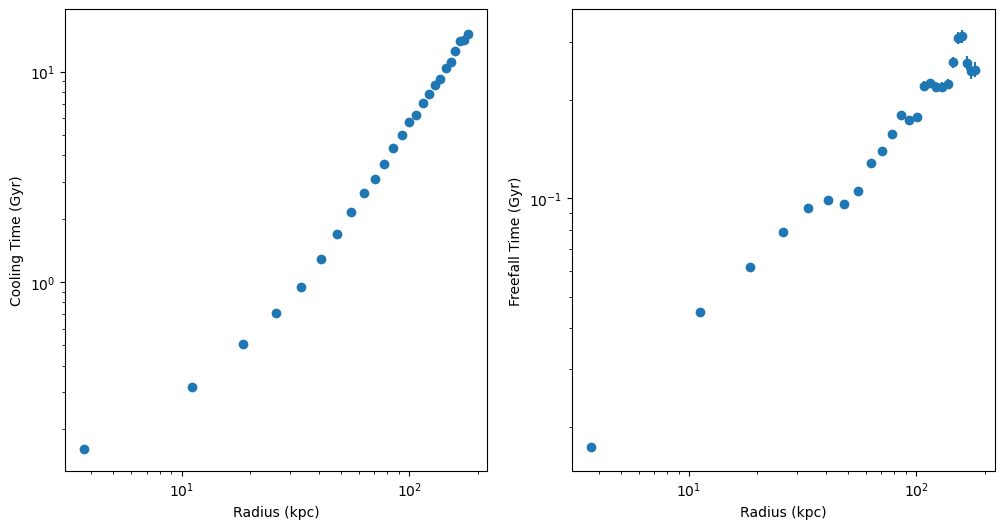

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axs = axes.ravel()

#ax1: cooling time
ax = axs[0]
ax.errorbar(radius_to_plot, cooling_time, yerr=cooling_time_err, fmt='o', label='Cooling Time')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Cooling Time (Gyr)')

#ax2: freefall time
ax = axs[1]
ax.errorbar(radius_to_plot, tff, yerr=tff_err, fmt='o', label='Freefall Time')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Freefall Time (Gyr)')